Filtrage
========

**Date:** vendredi 17 décembre 2021



## Capacité numérique



<p class="verse">
Simuler, à l’aide d’un langage de programmation, l'action d'un filtre sur un signal périodique dont le spectre est fourni. Mettre en évidence l'influence des caractéristiques du filtre sur l'opération de filtrage.<br />
</p>



## Modules



Le module `signal` de `scipy` ([documentation](https://docs.scipy.org/doc/scipy/reference/signal.html)) donne accès entre autres:

-   à des fonctions représentant des signaux usuels (créneau avec
    `square`, triangle et dents de scie avec `sawtooth`)
-   à des fonctions définissant des fonctions de transfert de filtres
    par les coefficients de leurs fractions rationnelles (fonction `freqs`)

Le module `fft` de `scipy` ([documentation](https:/docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fft.html)) permet entre autres de
réaliser les transformées de Fourier et transformées de Fourier
inverse (en utilisant l'algorithme de Fast Fourier Transform) pour:

-   à partir d'un signal f(t) numérisé, calculer une approximation
    numérique de son spectre de Fourier discret
-   à partir d'un spectre de Fourier discret, calculer la valeur d'une
    fonction correspondante en un ensemble d'instants.

Dans ces deux cas, l'ensemble des instants où est évaluée la fonction
et l'ensemble des fréquences où est évaluée sa transformée de Fourier
sont tous les deux discrets.

Le module `ma` de `numpy` ([documentation](https://numpy.org/doc/stable/reference/maskedarray.generic.html)) offre ici la facilité de
«masquer» certains éléments d'un tableau qu'on souhaite éliminer: ici
les parties du spectre de poids trop faible.



In [1]:
%matplotlib notebook

La ligne précédente ne doit apparaître que dans les notebooks
`Jupyter`, pas dans un fichier python.



In [2]:
import numpy as np
from scipy import signal
from scipy import fftpack
import matplotlib.pyplot as plt
import numpy.ma as ma

## Étude d'un filtre du premier ordre



### Définition



On définit un filtre passe-bas du premier ordre par son gain en bande
passante et sa fréquence de coupure.



In [3]:
pi = np.pi
# Définition du filtre
f_c = 2e2              # fréquence de coupure (en Hz)
omega_c = 2.0*pi*f_c   # pulsation de coupure (en rad/s)
H_0 = 2                # gain en bande passante   
# Coefficients du dénominateur rangés par degrés décroissants
a = np.array( [1/omega_c,1.0] )
# Coefficients du numérateur
b = np.array( [H_0] )
H_coeffs = (b,a)

### Diagramme de Bode



On fait calculer le module et l'argument de la fonction de transfert
pour un ensemble de fréquences déterminé, choisi en échelle
logarithmique: ici 400 fréquences équiréparties en échelle log entre
$10^1$ et $10^5$ Hz. La fonction `signal.freqs` renvoie:

-   `w` la liste des pulsations utilisées
-   `H` le tableau des valeurs (complexes) de la fonction de transfert
    pour ces pulsations.



In [4]:
# Plage de fréquence à étudier
frequences = np.logspace(1 , 5 , 400)
[ w, H ] = signal.freqs(b,a,2*pi*frequences)

On peut ensuite tracer le diagramme de Bode correspondant.



<IPython.core.display.Javascript object>


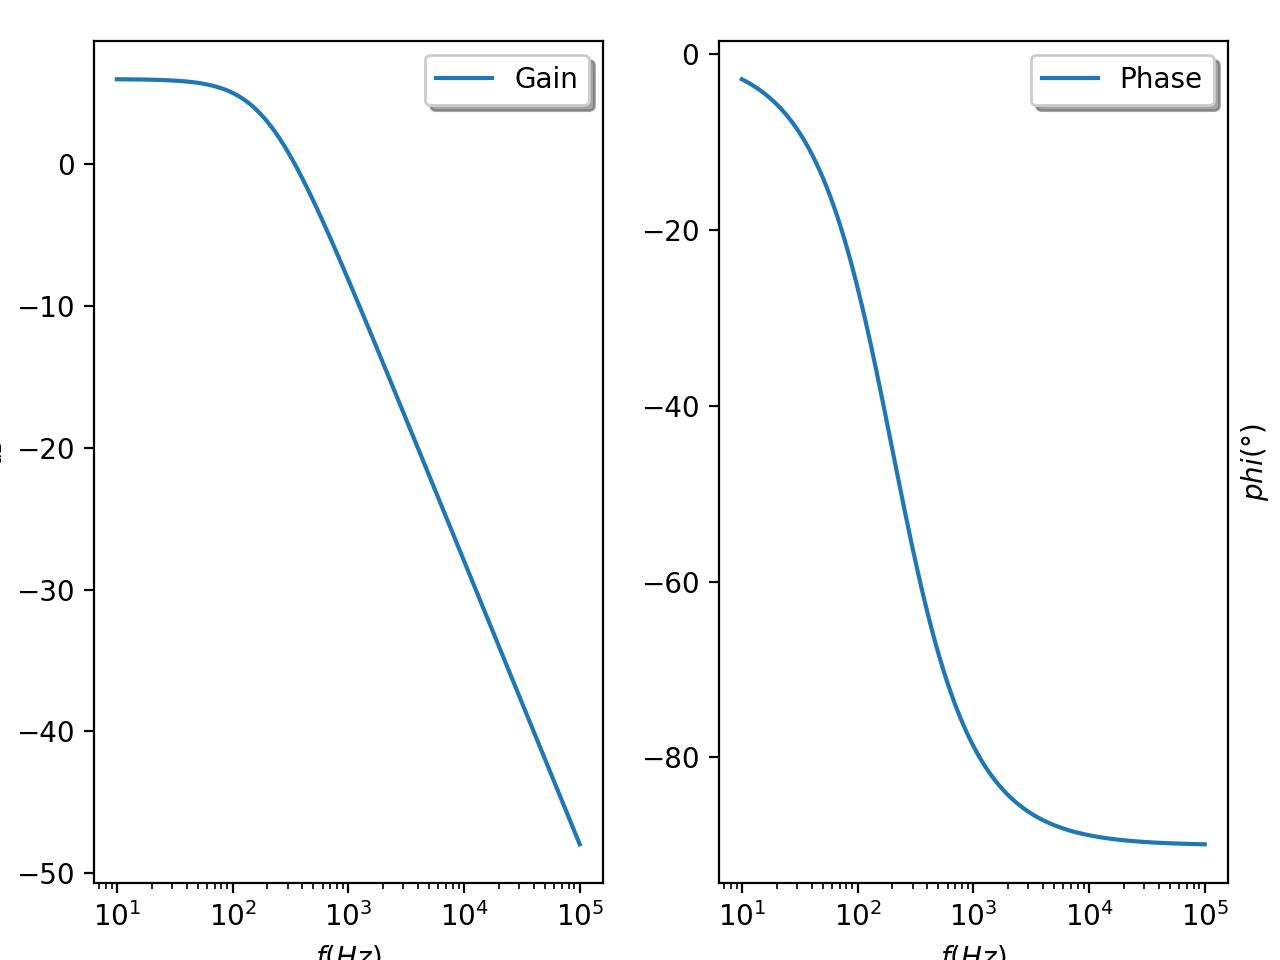

In [5]:
figBode1,(axBodeGain1,axBodePhase1) = plt.subplots(1,2) #pour avoir deux figures côte à côte
figBode1.tight_layout()
# gain en décibel, np.absolute calcule le module
G = 20.0 * np.log10(np.absolute(H))
# phase en degrés, np.angle calcule l'argument en radian, converti par rad2deg
phase = np.rad2deg(np.angle(H))
axBodeGain1.semilogx()
axBodePhase1.semilogx()
axBodeGain1.plot(frequences,G,label='Gain')
axBodeGain1.set_xlabel(r"$f(Hz)$")
axBodeGain1.set_ylabel(r"$G_{dB}$" )
axBodePhase1.plot(frequences,phase,label='Phase')
axBodePhase1.set_xlabel(r"$f(Hz)$")
axBodePhase1.set_ylabel(r"$phi(°)$")
axBodePhase1.yaxis.set_label_position("right")
axBodePhase1.legend(loc='best',shadow=True)
axBodeGain1.legend(loc='best',shadow=True)
figBode1.show()

## Simulation du filtrage



### Échantillonage de la fonction



On calcule les valeurs de la fonction sur laquelle sera appliquée le
filtre sur un échantillon d'instants. La durée entre deux instants
`Delta_t` doit être suffisamment courte pour que deux fonctions
différentes n'aient pas le même échantillonage. On utilisera le
«critère de Shannon» selon lequel `Delta_t = 1/(2 fmax)` avec `fmax` la
fréquence maximale du spectre du signal.

On utilise ici une fonction créneau de fréquence `fCre`. Pour
que son échantillonnage reproduise fidèlement ses harmoniques jusqu'au
rang `9`, on doit donc échantillonner avec `Delta_t = 1/(18 fCre)`. On
rajoute un facteur `10` pour augmenter la précision.



<IPython.core.display.Javascript object>


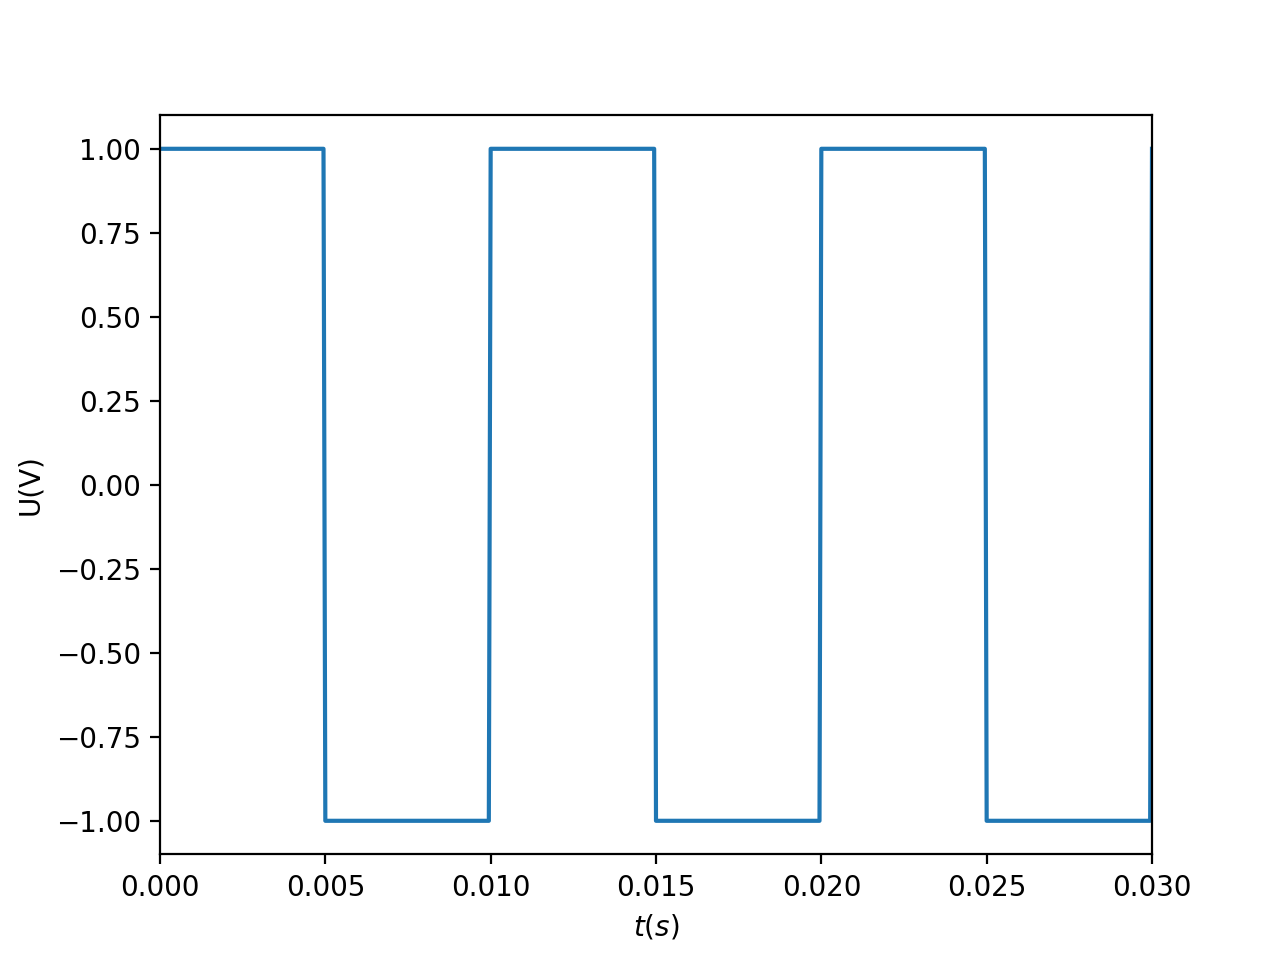

In [6]:
HarmoniqueMax = 9
fCre = 100 #Hz
Delta_t = 1/(20*HarmoniqueMax*fCre)
echantillon_t = np.arange(0,20/fCre,Delta_t) # pour disposer de 20 périodes pour l'échantillonage
EntreeCreneau = signal.square(echantillon_t*2*pi*fCre) # signal.square a pour période 2 pi
figCreneau,axCreneau = plt.subplots()
axCreneau.set_xlim(0,3/fCre)
axCreneau.plot(echantillon_t,EntreeCreneau)
axCreneau.set_xlabel(r"$t(s)$")
axCreneau.set_ylabel(r"U(V)" )
figCreneau.show()

### Transformée de Fourier rapide



On calcule les fréquences `FrequencesFFTCreneau` adaptées à
l'échantillonage avec `fftfreq`. On applique la transformée de Fourier
rapide au signal échantillonné avec `fft` pour obtenir
`FFTEntreeCreneau`, un tableau des amplitudes complexes des composantes
de Fourier de `EntreeCreneau`. Le masque `mask` permet de ne garder à
l'affichage que les composantes de Fourier dont l'amplitude est
supérieure à un seuil.

On trace ensuite les modules de ces amplitudes complexes.



<IPython.core.display.Javascript object>


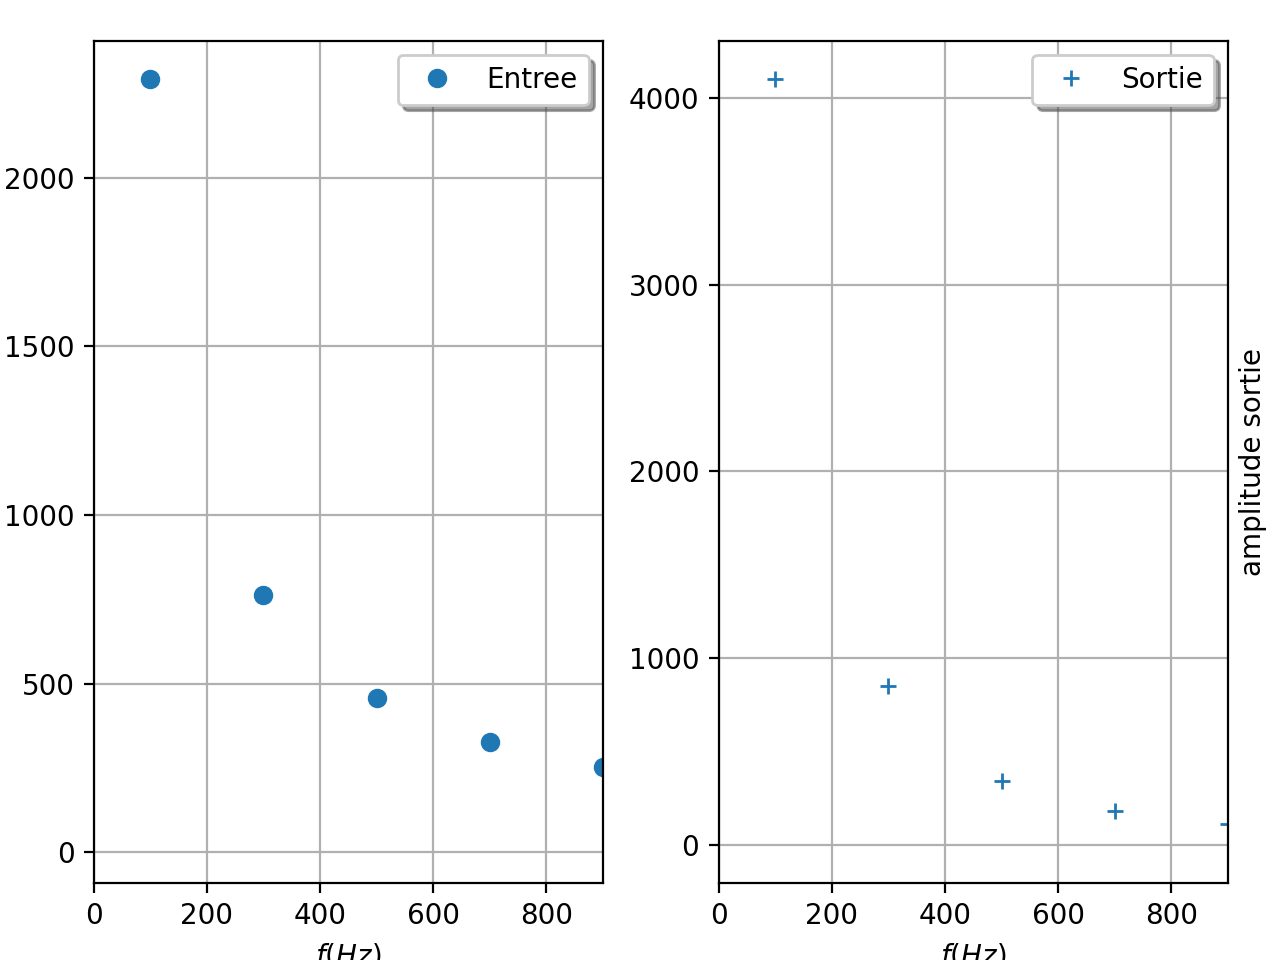

In [7]:
FrequencesFFTCreneau =  fftpack.fftfreq(len(EntreeCreneau) , Delta_t)
FFTEntreeCreneau = fftpack.fft(EntreeCreneau)
CutoffGdB=40
FFTEntreeCreneauGdB=20*np.log10(np.absolute(FFTEntreeCreneau))
mask=ma.masked_less(FFTEntreeCreneauGdB,np.max(FFTEntreeCreneauGdB)-CutoffGdB).mask
FrequencesFFTCreneauMasked=FrequencesFFTCreneau[~mask]
FFTEntreeCreneauMasked=FFTEntreeCreneau[~mask]
FFTEntreeCreneauGdBMasked=FFTEntreeCreneauGdB[~mask]
figFFTCreneau,(axFFTEntreeCreneau,axFFTSortieCreneau) = plt.subplots(1,2) #pour avoir deux figures côte à côte
figFFTCreneau.tight_layout()
axFFTEntreeCreneau.plot(FrequencesFFTCreneauMasked, np.absolute(FFTEntreeCreneauMasked), 'o', label='Entree')
axFFTEntreeCreneau.set_xlabel(r"$f(Hz)$")
axFFTEntreeCreneau.set_ylabel(r"amplitude entrée" )
axFFTEntreeCreneau.set_xlim([0, HarmoniqueMax*fCre])
axFFTEntreeCreneau.grid(which='both')

On évalue ensuite les valeurs du gain complexe `HFFTCreneau` calculé
pour ces fréquences puis on multiplie une à une les amplitudes de
`FFTEntreeCreneau` par la valeur du gain `HFFTCreneau` pour obtenir la
transformée de Fourier discrète du signal de sortie
`FFTSortieCreneau`.



In [8]:
HFFTCreneau = signal.freqs(b,a,2*pi*FrequencesFFTCreneau)[1]
FFTSortieCreneau = HFFTCreneau * FFTEntreeCreneau
FFTSortieCreneauMasked = FFTSortieCreneau[~mask]
axFFTSortieCreneau.plot(FrequencesFFTCreneauMasked, np.absolute(FFTSortieCreneauMasked), '+', label='Sortie')
axFFTSortieCreneau.set_xlabel(r"$f(Hz)$")
axFFTSortieCreneau.set_ylabel(r"amplitude sortie" )
axFFTSortieCreneau.set_xlim([0, HarmoniqueMax*fCre])
axFFTSortieCreneau.grid(which='both')
axFFTSortieCreneau.yaxis.set_label_position("right")
axFFTSortieCreneau.legend(loc='best',shadow=True)
axFFTEntreeCreneau.legend(loc='best',shadow=True)
figFFTCreneau.show()

Il suffit ensuite d'utiliser la transformée de Fourier Inverse `ifft` 
pour retrouver la fonction en sortie de filtre, qu'on superpose à la
fonction en entrée pour les comparer.

L'algorithme d'aller-et-retour entre `fft` et `ifft` peut faire
apparaître des parties imaginaires dans le signal de
sortie. On vérifie qu'elles sont négligeables avec `max(np.imag)` et
on ne trace que la partie réelle



<IPython.core.display.Javascript object>


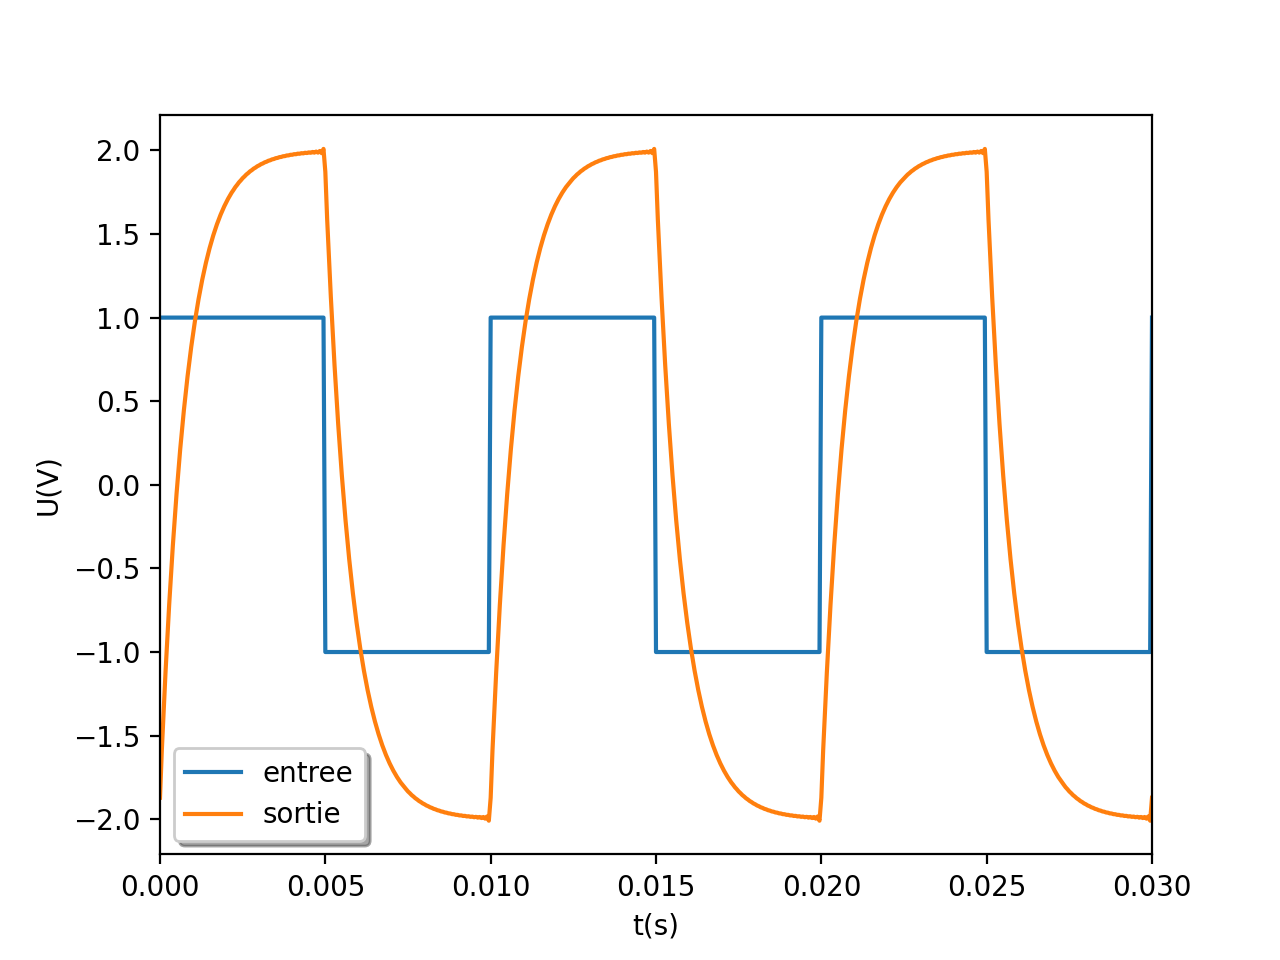

max des parties imaginaires 7.40375123402933e-05


In [9]:
SortieCreneau = fftpack.ifft(FFTSortieCreneau)
figCreneauES,axCreneauES = plt.subplots()
axCreneauES.plot(echantillon_t,EntreeCreneau,label='entree')
print(f'max des parties imaginaires {max(np.imag(SortieCreneau))}')
axCreneauES.plot(echantillon_t, np.real(SortieCreneau), label='sortie') 
axCreneauES.set_xlim([0, 3/fCre])
axCreneauES.set_xlabel(r't(s)')
axCreneauES.set_ylabel(r'U(V)')
axCreneauES.legend(loc='best',shadow=True)
figCreneauES.show()

## Questions du DM05



### II4a



<IPython.core.display.Javascript object>


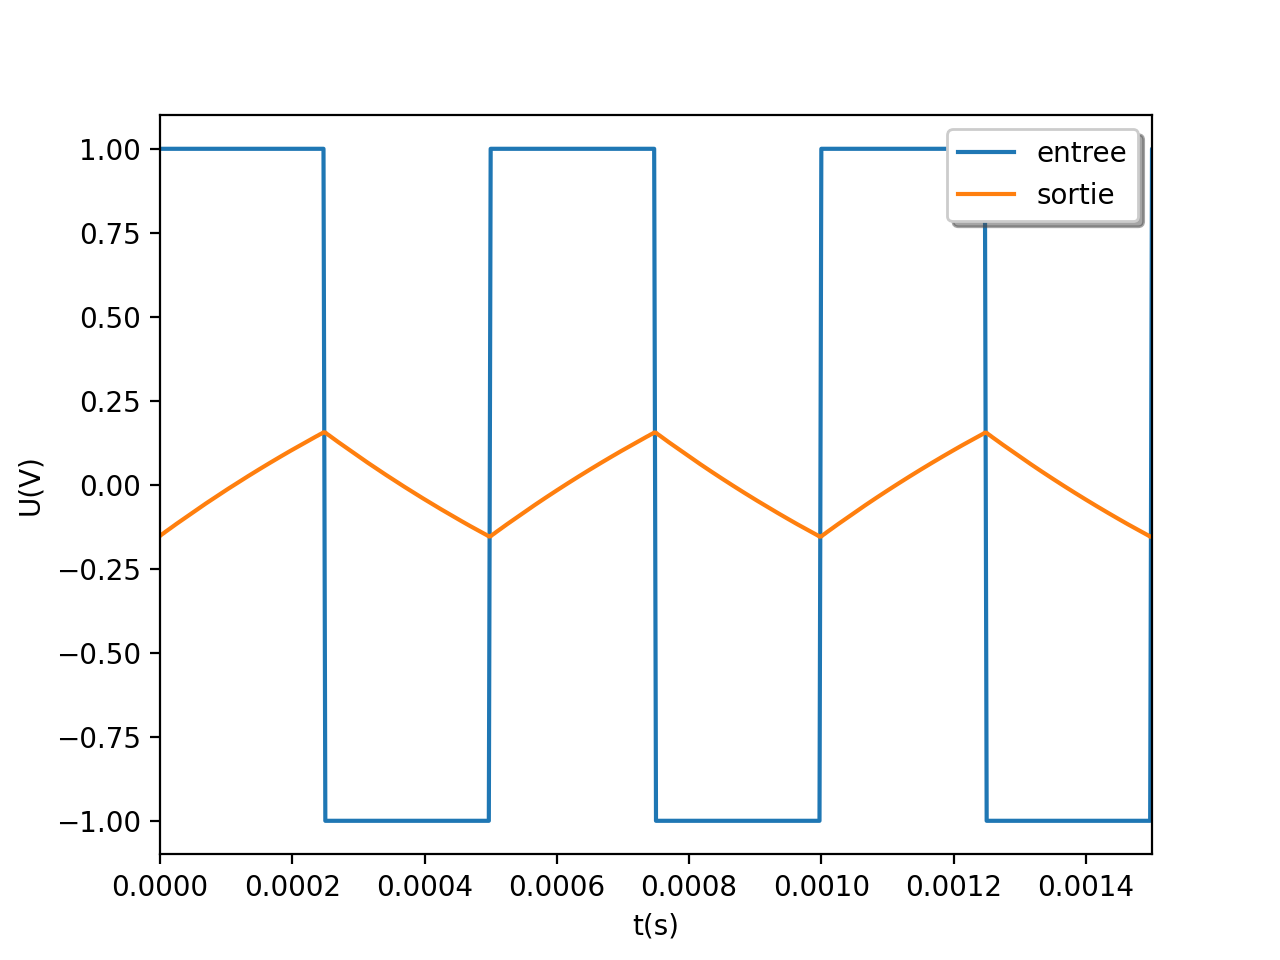

max des parties imaginaires 2.4691327541904573e-06


In [10]:
# Définition du filtre
DMf_c = 2e2              # fréquence de coupure (en Hz)
DMomega_c = 2.0*pi*DMf_c   # pulsation de coupure (en rad/s)
DMH_0 = 1                # gain en bande passante   
# Coefficients du dénominateur rangés par degrés décroissants
DMa = np.array( [1/DMomega_c,1.0] )
# Coefficients du numérateur
DMb = np.array( [DMH_0] )
DMH_coeffs = (DMb,DMa)
DMHarmoniqueMax = 9
DMfCre = 2e3 #Hz
DMCreneauAmplitude = 1
DMDelta_t = 1/(20*DMHarmoniqueMax*DMfCre)
DMechantillon_t = np.arange(0,20/DMfCre,DMDelta_t) # pour disposer de 20 périodes pour l'échantillonage
DMEntreeCreneau = DMCreneauAmplitude * signal.square(DMechantillon_t*2*pi*DMfCre) # signal.square a pour période 2 pi
DMFrequencesFFTCreneau =  fftpack.fftfreq(len(DMEntreeCreneau) , DMDelta_t)
DMFFTEntreeCreneau = fftpack.fft(DMEntreeCreneau)
DMCutoffGdB=40
DMFFTEntreeCreneauGdB=20*np.log10(np.absolute(DMFFTEntreeCreneau))
DMmask=ma.masked_less(DMFFTEntreeCreneauGdB,np.max(DMFFTEntreeCreneauGdB)-DMCutoffGdB).mask
DMFrequencesFFTCreneauMasked=DMFrequencesFFTCreneau[~DMmask]
DMFFTEntreeCreneauMasked = DMFFTEntreeCreneau[~DMmask]
DMFFTEntreeCreneauGdBMasked = DMFFTEntreeCreneauGdB[~DMmask]
DMHFFTCreneau = signal.freqs(DMb,DMa,2*pi*DMFrequencesFFTCreneau)[1]
DMFFTSortieCreneau = DMHFFTCreneau * DMFFTEntreeCreneau
DMFFTSortieCreneauMasked = DMFFTSortieCreneau[~DMmask]
DMSortieCreneau = fftpack.ifft(DMFFTSortieCreneau)
figDMCreneauES,axDMCreneauES = plt.subplots()
axDMCreneauES.plot(DMechantillon_t,DMEntreeCreneau,label='entree')
print(f'max des parties imaginaires {max(np.imag(DMSortieCreneau))}')
axDMCreneauES.plot(DMechantillon_t, np.real(DMSortieCreneau), label='sortie') 
axDMCreneauES.set_xlim([0, 3/DMfCre])
axDMCreneauES.set_xlabel(r't(s)')
axDMCreneauES.set_ylabel(r'U(V)')
axDMCreneauES.legend(loc='best',shadow=True)
figDMCreneauES.show()

On calcule ensuite l'amplitude du signal triangulaire obtenu:



In [11]:
print(f'amplitude: {(max(np.real(DMSortieCreneau)) - min(np.real(DMSortieCreneau)))/2} V/')

amplitude: 0.1585060028538109 V/


### II4c



On change simplement le signal d'entrée:



<IPython.core.display.Javascript object>


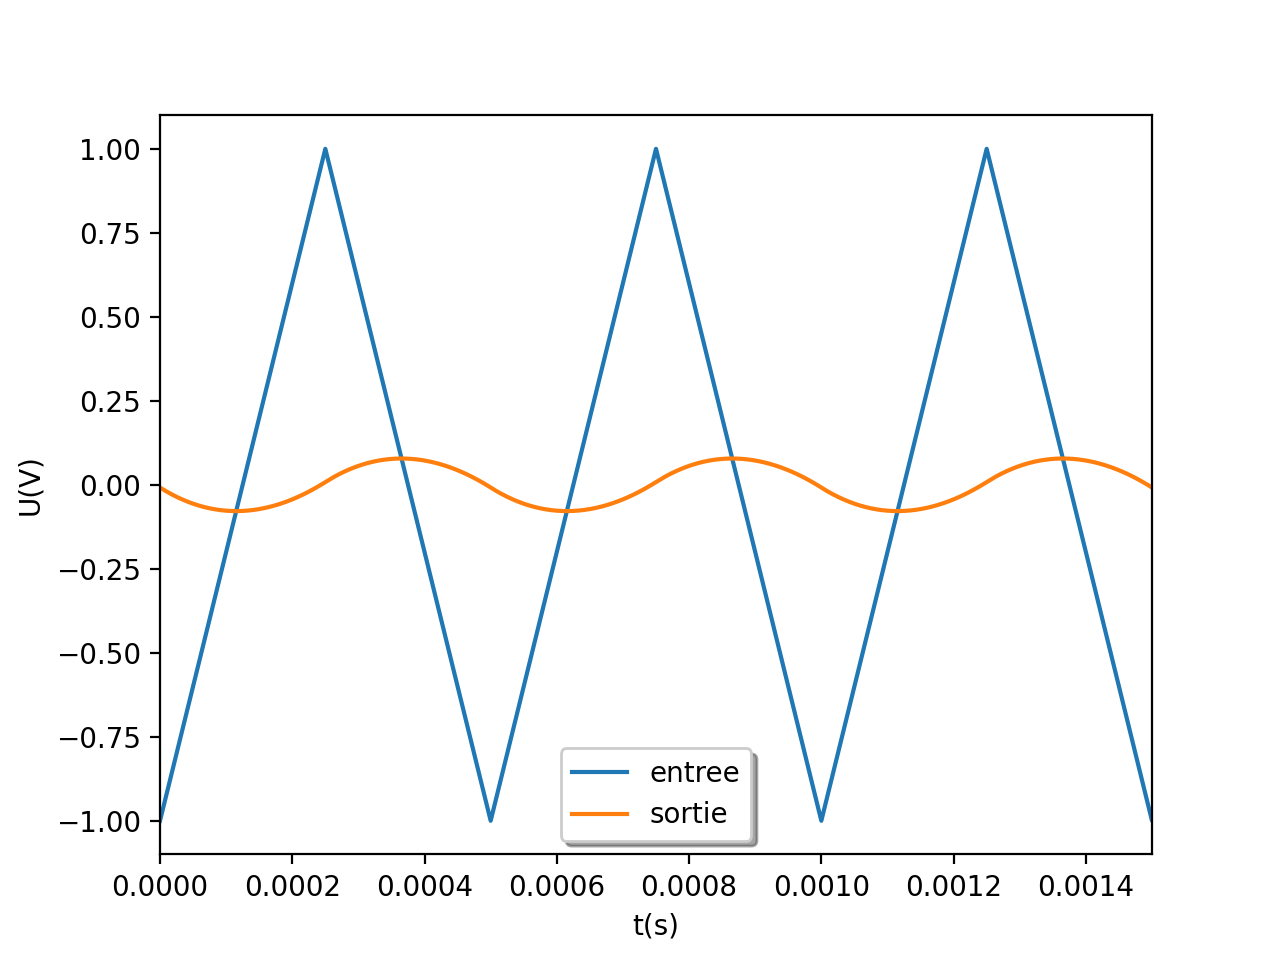

max des parties imaginaires 2.3876331575316198e-17


In [12]:
DMTriAmplitude = 1
DMEntreeTri = DMTriAmplitude * signal.sawtooth(DMechantillon_t*2*pi*DMfCre, width=.5) # signal.sawtooth a pour période 2 pi
DMFrequencesFFTTri =  fftpack.fftfreq(len(DMEntreeTri) , DMDelta_t)
DMFFTEntreeTri = fftpack.fft(DMEntreeTri)
DMFFTEntreeTriGdB=20*np.log10(np.absolute(DMFFTEntreeTri))
DMmask=ma.masked_less(DMFFTEntreeTriGdB,np.max(DMFFTEntreeTriGdB)-DMCutoffGdB).mask
DMFrequencesFFTTriMasked=DMFrequencesFFTTri[~DMmask]
DMFFTEntreeTriMasked = DMFFTEntreeTri[~DMmask]
DMFFTEntreeTriGdBMasked = DMFFTEntreeTriGdB[~DMmask]
DMHFFTTri = signal.freqs(DMb,DMa,2*pi*DMFrequencesFFTTri)[1]
DMFFTSortieTri = DMHFFTTri * DMFFTEntreeTri
DMFFTSortieTriMasked = DMFFTSortieTri[~DMmask]
DMSortieTri = fftpack.ifft(DMFFTSortieTri)
figDMTriES,axDMTriES = plt.subplots()
axDMTriES.plot(DMechantillon_t,DMEntreeTri,label='entree')
print(f'max des parties imaginaires {max(np.imag(DMSortieTri))}')
axDMTriES.plot(DMechantillon_t, np.real(DMSortieTri), label='sortie') 
axDMTriES.set_xlim([0, 3/DMfCre])
axDMTriES.set_xlabel(r't(s)')
axDMTriES.set_ylabel(r'U(V)')
axDMTriES.legend(loc='best',shadow=True)
figDMTriES.show()

### III4b



On change simplement la fonction de transfert, de coefficients
`DM2a`. On trace la courbe du signal de sortie ainsi que les spectres
de Fourier des signaux d'entrée et de sortie: on y vérifie bien que
les amplitudes du fondamental et de la 2\ieme harmonique sont bien
très proches\footnote{La différence, de l'ordre de $\num{5}\%$, est
vraisemblablement une erreur d'arrondi qui existait déjà dans le
spectre du signal d'entrée dont l'amplitude n'était pas exactement
$\num{20}\%$ de celle du fondamental.} 

On trace également à titre de comparaison la somme:

$$
\cos(2\pi f_Cr t) + \cos(10\pi f_Cr t - \pi/2),
$$

qui ressemble au signal produit par le filtre mais en diffère
significativement car l'harmonique de rang $\num{3}$ possède une
amplitude non négligeable.



<IPython.core.display.Javascript object>


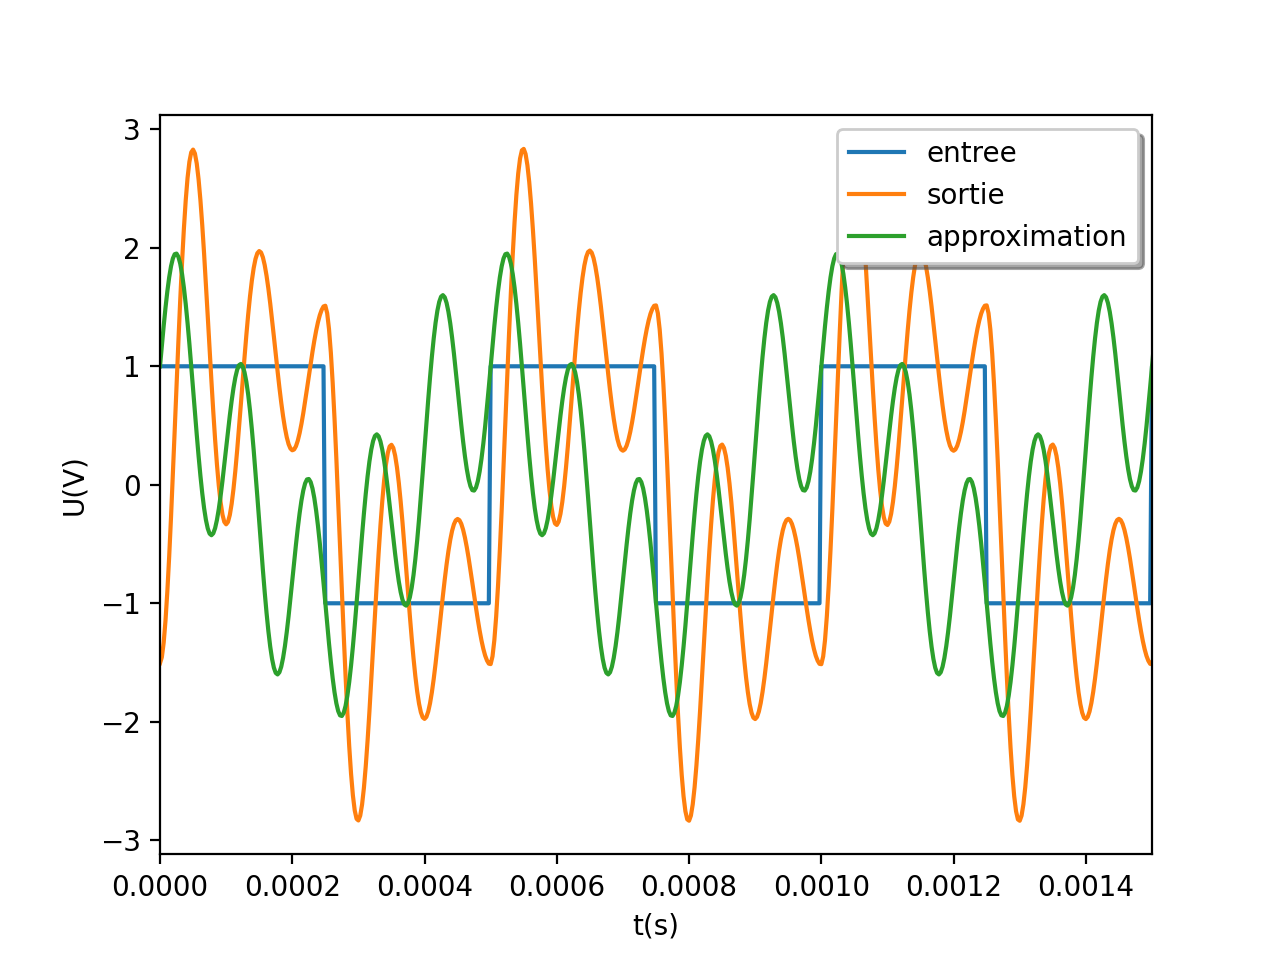

max des parties imaginaires 7.667097750257357e-08


In [13]:
# Définition du filtre
DM2fCre = 2e3 #Hz
DM2CreneauAmplitude = 1
DM2f_c = 5*DM2fCre              # 5x la fréquence du créneau
DM2Q = 5
DM2omega_c = 2.0*pi*DM2f_c   # pulsation de coupure (en rad/s)
DM2H_0 = 1                # gain en bande passante   
# Coefficients du dénominateur rangés par degrés décroissants
DM2a = np.array( [1/(DM2omega_c)**2, 1/(DM2omega_c*DM2Q), 1.0] )
# Coefficients du numérateur
DM2b = np.array( [DM2H_0] )
DM2H_coeffs = (DM2b,DM2a)
DM2HarmoniqueMax = 9
DM2Delta_t = 1/(20*DM2HarmoniqueMax*DM2fCre)
DM2echantillon_t = np.arange(0,20/DM2fCre,DM2Delta_t) # pour disposer de 20 périodes pour l'échantillonage
DM2EntreeCreneau = DM2CreneauAmplitude * signal.square(DM2echantillon_t*2*pi*DM2fCre) # signal.square a pour période 2 pi
DM2FrequencesFFTCreneau =  fftpack.fftfreq(len(DM2EntreeCreneau) , DM2Delta_t)
DM2FFTEntreeCreneau = fftpack.fft(DM2EntreeCreneau)
DM2CutoffGdB=40
DM2FFTEntreeCreneauGdB=20*np.log10(np.absolute(DM2FFTEntreeCreneau))
DM2mask=ma.masked_less(DM2FFTEntreeCreneauGdB, np.max(DM2FFTEntreeCreneauGdB)- DM2CutoffGdB).mask
DM2FrequencesFFTCreneauMasked=DM2FrequencesFFTCreneau[~DM2mask]
DM2FFTEntreeCreneauMasked = DM2FFTEntreeCreneau[~DM2mask]
DM2FFTEntreeCreneauGdBMasked = DM2FFTEntreeCreneauGdB[~DM2mask]
DM2HFFTCreneau = signal.freqs(DM2b,DM2a,2*pi*DM2FrequencesFFTCreneau)[1]
DM2FFTSortieCreneau = DM2HFFTCreneau * DM2FFTEntreeCreneau
DM2FFTSortieCreneauMasked = DM2FFTSortieCreneau[~DM2mask]
DM2SortieCreneau = fftpack.ifft(DM2FFTSortieCreneau)

DM2Approx = np.cos(2*pi*DM2fCre*DM2echantillon_t) + np.cos(10*pi*DM2fCre*DM2echantillon_t - np.pi/2)

figDM2CreneauES,axDM2CreneauES = plt.subplots()
axDM2CreneauES.plot(DM2echantillon_t,DM2EntreeCreneau,label='entree')
print(f'max des parties imaginaires {max(np.imag(DM2SortieCreneau))}')
axDM2CreneauES.plot(DM2echantillon_t, np.real(DM2SortieCreneau), label='sortie')
axDM2CreneauES.plot(DM2echantillon_t, DM2Approx, label='approximation') 
axDM2CreneauES.set_xlim([0, 3/DM2fCre])
axDM2CreneauES.set_xlabel(r't(s)')
axDM2CreneauES.set_ylabel(r'U(V)')
axDM2CreneauES.legend(loc='best',shadow=True)
figDM2CreneauES.show()

<IPython.core.display.Javascript object>


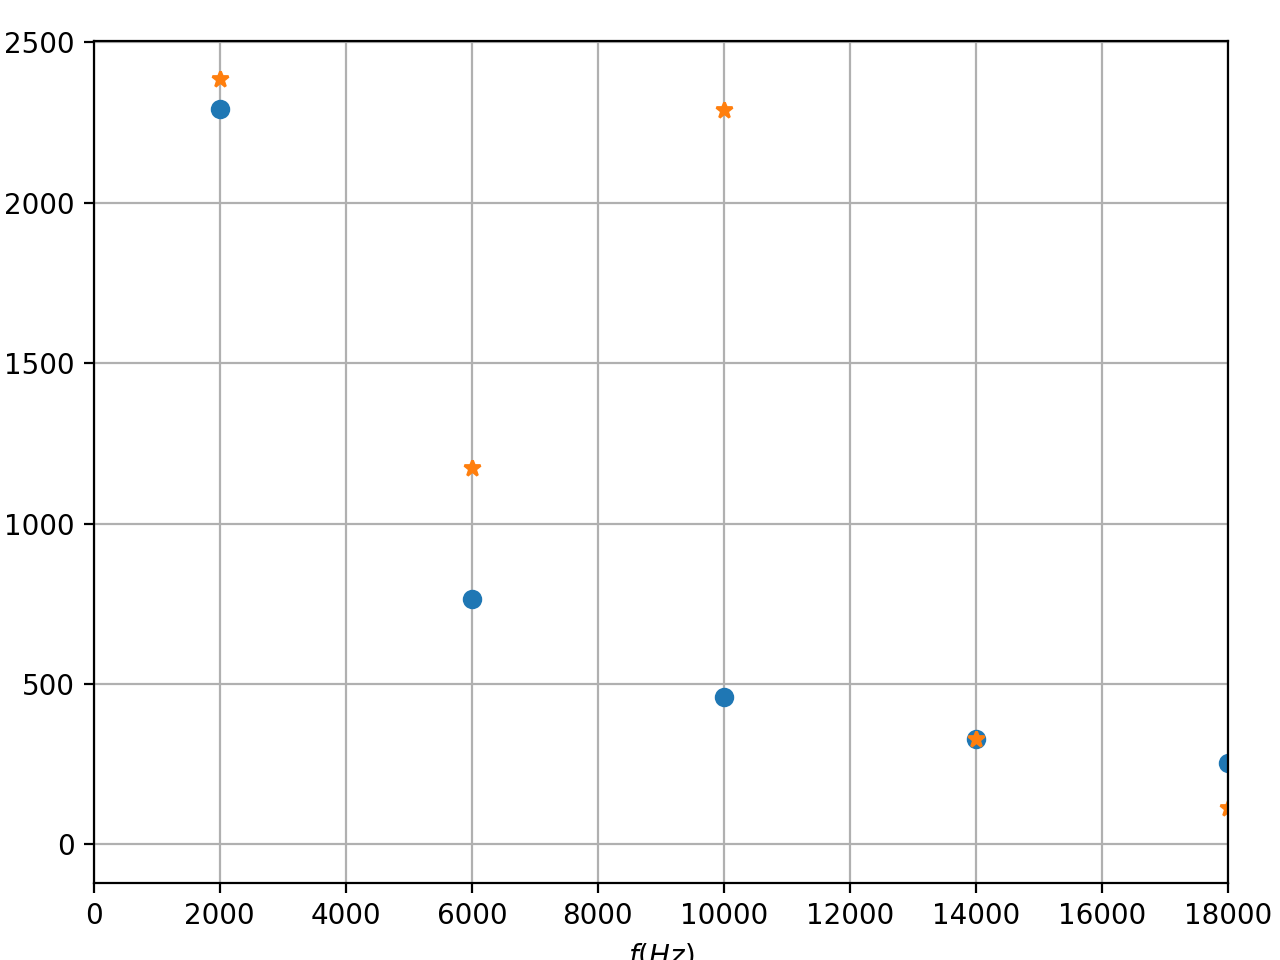

In [14]:
figDM2FFT,axDM2FFT = plt.subplots()
figDM2FFT.tight_layout()
axDM2FFT.plot(DM2FrequencesFFTCreneauMasked, np.absolute(DM2FFTEntreeCreneauMasked), 'o', label='Entree')
axDM2FFT.plot(DM2FrequencesFFTCreneauMasked, np.absolute(DM2FFTSortieCreneauMasked), '*', label='Sortie')
axDM2FFT.set_xlabel(r"$f(Hz)$")
axDM2FFT.set_ylabel(r"amplitude entrée" )
axDM2FFT.set_xlim([0, HarmoniqueMax*DM2fCre])
axDM2FFT.grid(which='both')
figDM2FFT.show()